# Carte de contrôle

## 0 - Connexion a la BDD

In [205]:
import psycopg
import matplotlib.pyplot as plt
from datetime import timedelta, datetime


# Connexion settings
conn_settings = {
  "host": "localhost",
  "dbname": "db",
  "user": "postgres",
  "password": "patate360",
  "port": 5432
}

conn = psycopg.connect(**conn_settings)

idSensor = 1 # Constant to select the sensor

In [196]:
# Check if the sensor exists in the database
sql = """
SELECT * FROM Sensor WHERE sensorid = %(id)s 
"""

param = {"id": idSensor}

with conn.execute(sql, param) as cur:
  row = cur.fetchone()
  if(row == None):
    raise Exception("No sensor associated with this id")

## 1 - Cartes de contrôle

In [197]:
# Get the last manual measurement for the selected sensor
def getLastMeasure(): 
  sql = """
  SELECT max(controltimestamp) FROM controlMeasurement
  WHERE sensorid = %(id)s 
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [198]:
# Get the error values for the last 8 days up to a limit of 100 items, 
# and if the number of items is less than 20, extend the period bayond 8 days.
# Each error value is associated with the time the measurements were made
def getDataControlCard(): 
  # Used to retrieve values within an 8 days interval from the last measurement
  limitDays = getLastMeasure() - timedelta(days = 8)

  sql = """
  SELECT controlValue - sensorValue, cm.controltimestamp
  FROM ControlMeasurement cm
  JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
  WHERE cm.sensorid = %(id)s
  ORDER BY cm.controltimestamp DESC
  LIMIT 100
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    rows = []
    line = cur.fetchone()
    
    # Guarantee that we have at least 20 values to display
    while(line != None and (len(rows) < 20 or line[1] >= limitDays)):
      rows.append(line)
      line = cur.fetchone()

    # Reverse the list to have the data in the correct order
    rows.reverse()
    return rows

In [199]:
# Get the average of the erreur values
def getMeanErrorValue():
  sql = """
    SELECT avg(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [200]:
# Get the stddev of the erreur values
def getStddevErrorValue():
  sql = """
    SELECT stddev(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [201]:
# Show control chart
def showControlCard():
  # Get data needed for display
  data = getDataControlCard()
  mean = getMeanErrorValue()
  stddev = getStddevErrorValue()

  # Format the data
  x = []
  y = []
  for el in data:
    y.append(el[0])
    x.append(el[1])

  # Show Data
  plt.figure(figsize=(12, 8))
  
  plt.plot(x, y, label='Données')
  plt.plot([data[0][1], data[-1][1]], [mean, mean], label='Moyenne')
  plt.plot([data[0][1], data[-1][1]], [mean + 2 * stddev, mean + 2 * stddev], c="Red", lw=2, label='Upper Control Limit')
  plt.plot([data[0][1], data[-1][1]], [mean - 2 * stddev, mean - 2 * stddev], c="Black", lw=2, label='Lower Control Limit')
  
  plt.title('Carte de contrôle')
  plt.xlabel('Temps')
  plt.ylabel('Mesure de l\'erreur')
  plt.legend(bbox_to_anchor=(1, 1)) # Place the legend outside the chart
  plt.xticks(rotation=30) # For better readability

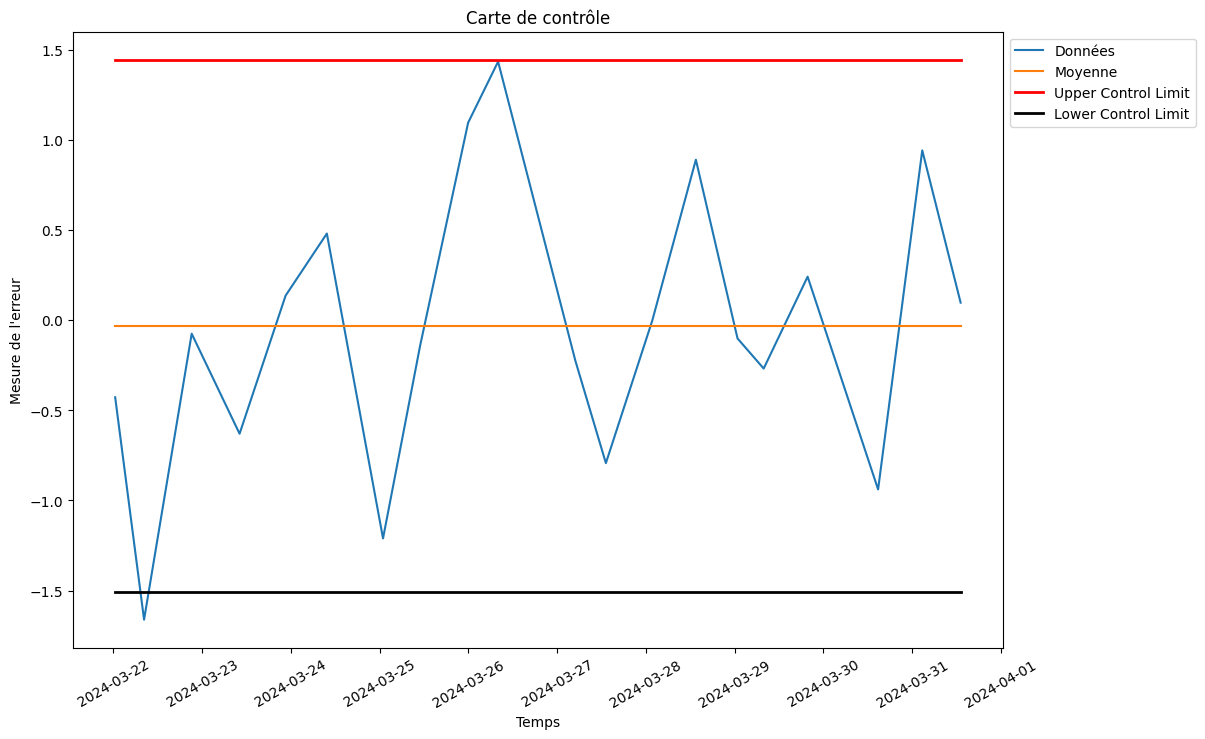

In [202]:
showControlCard()

## 2 - Statistiques
### 2.1 - Visualisation des marges d'erreur

In [ ]:
def getProportion():
  sql = """
    SELECT controlValue - sensorValue
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s
  """

  param = {"id": idSensor}

  counts = [0, 0, 0, 0, 0, 0, 0, 0]
  total = 0

  stddev = getStddevErrorValue()

  with conn.execute(sql, param) as cur:
    for row in cur:
      haveBeenCount = False

      for i in range(3):
        if(row[0] >= -(i + 1) * stddev and row[0] <= (i + 1) * stddev):
          if(row[0] < 0):
            counts[i * 2] += 1
          else:
            counts[i * 2 + 1] += 1

          haveBeenCount = True
          break

      if (not haveBeenCount):
        if(row[0] > 0):
          counts[7] += 1
        else:
          counts[6] += 1

      total += 1

    percentages = []
    for i in range(6, -1, -2):
      percentages.append(round(counts[i] / total * 100, 2))
    for i in range(1, 8, 2):
      percentages.append(counts[i] / total * 100)

    return percentages
  
a, b, c, d, e, f, g, h = getProportion()

print(a, b, c, d, e, f, g, h, a+b+c+d+e+f+g+h)

0.6483790523690772 2.0947630922693268 11.271820448877804 35.461346633416454 35.910224438902745 12.26932668329177 1.945137157107232 0.399002493765586 99.99999999999997
